In [299]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from IPython.display import HTML

import warnings
warnings.filterwarnings("ignore")

In [300]:
df = pd.read_csv('supermarket.csv')
df.tail(3)

,SHOP_WEEK,SHOP_DATE,SHOP_WEEKDAY,SHOP_HOUR,QUANTITY,SPEND,PROD_CODE,PROD_CODE_10,PROD_CODE_20,PROD_CODE_30,...,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,BASKET_ID,BASKET_SIZE,BASKET_PRICE_SENSITIVITY,BASKET_TYPE,BASKET_DOMINANT_MISSION,STORE_CODE,STORE_FORMAT,STORE_REGION
578079,200637,20061109,5,16,1,4.47,PRD0900396,CL00229,DEP00081,G00027,...,UM,NaN,994103100229855,L,MM,Full Shop,Mixed,STORE00001,LS,E02
578080,200717,20070624,1,10,1,4.92,PRD0903065,CL00229,DEP00081,G00027,...,UM,YF,994106300437841,L,MM,Full Shop,Mixed,STORE00001,LS,E02
578081,200744,20071229,7,14,1,9.27,PRD0901923,CL00229,DEP00081,G00027,...,UM,NaN,994109000359411,L,MM,Top Up,Mixed,STORE00001,LS,E02


In [301]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578082 entries, 0 to 578081
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SHOP_WEEK                 578082 non-null  int64  
 1   SHOP_DATE                 578082 non-null  int64  
 2   SHOP_WEEKDAY              578082 non-null  int64  
 3   SHOP_HOUR                 578082 non-null  int64  
 4   QUANTITY                  578082 non-null  int64  
 5   SPEND                     578082 non-null  float64
 6   PROD_CODE                 578082 non-null  object 
 7   PROD_CODE_10              578082 non-null  object 
 8   PROD_CODE_20              578082 non-null  object 
 9   PROD_CODE_30              578082 non-null  object 
 10  PROD_CODE_40              578082 non-null  object 
 11  CUST_CODE                 492494 non-null  object 
 12  CUST_PRICE_SENSITIVITY    492494 non-null  object 
 13  CUST_LIFESTAGE            433142 non-null  o

In [302]:
# Clean missing values
df.dropna(subset=['CUST_CODE'], inplace=True)
df['CUST_LIFESTAGE'] = df['CUST_LIFESTAGE'].fillna('XX')
df.isna().sum()

SHOP_WEEK                   0
SHOP_DATE                   0
SHOP_WEEKDAY                0
SHOP_HOUR                   0
QUANTITY                    0
SPEND                       0
PROD_CODE                   0
PROD_CODE_10                0
PROD_CODE_20                0
PROD_CODE_30                0
PROD_CODE_40                0
CUST_CODE                   0
CUST_PRICE_SENSITIVITY      0
CUST_LIFESTAGE              0
BASKET_ID                   0
BASKET_SIZE                 0
BASKET_PRICE_SENSITIVITY    0
BASKET_TYPE                 0
BASKET_DOMINANT_MISSION     0
STORE_CODE                  0
STORE_FORMAT                0
STORE_REGION                0
dtype: int64

In [303]:
# clean data type
df['SHOP_DATE'] = pd.to_datetime(df['SHOP_DATE'], format='%Y%m%d')
df['SHOP_MONTH'] = df['SHOP_DATE'].dt.to_period('m')
df['BASKET_ID'] = df['BASKET_ID'].astype(str)

In [304]:
df[['QUANTITY', 'SPEND']].describe().apply(lambda x: x.apply('{0:.5f}'.format)).transpose()

,count,mean,std,min,25%,50%,75%,max
QUANTITY,492494.00000,1.52764,1.57281,1.00000,1.00000,1.00000,1.00000,129.00000
SPEND,492494.00000,1.92788,2.69127,0.01000,0.77000,1.24000,2.11000,346.46000


In [305]:
print(f"min date :{df['SHOP_DATE'].min()}")
print(f"max date :{df['SHOP_DATE'].max()}")

min date :2006-04-10 00:00:00
max date :2008-07-06 00:00:00


## Customer Single View

In [306]:
# find most buying pdt for each customers
cust_dict = {'CUST_CODE':[],
            'most_buying_pdt':[]}

cust_pdt = df.groupby(['CUST_CODE','PROD_CODE'])['PROD_CODE'].agg(qty='count').reset_index()

for i in cust_pdt['CUST_CODE'].unique():
    cust_dict['CUST_CODE'].append(i)
    cust = cust_pdt.loc[cust_pdt['CUST_CODE']==i,:]

    if len(cust.loc[cust['qty']==cust['qty'].max()]['PROD_CODE']) == 1:
        cust_dict['most_buying_pdt'].append(cust.loc[cust['qty']==cust['qty'].max()]['PROD_CODE'].reset_index(drop=True)[0])
    elif len(cust.loc[cust['qty']==cust['qty'].max()]['PROD_CODE']) > 1:
        # if most buying pdt more than one convert to list
        cust_dict['most_buying_pdt'].append(list(cust.loc[cust['qty']==cust['qty'].max()]['PROD_CODE']))

In [307]:
# create single customer view
df_scv = df[['CUST_CODE']].drop_duplicates().reset_index(drop=True)

# aggregate for total period
df_scv = df_scv.merge(
    df.groupby(['CUST_CODE', 'BASKET_ID']).agg(
    spend = ('SPEND', 'sum'),
    first_visit = ('SHOP_DATE', 'min'),
    last_visit = ('SHOP_DATE', 'max')).reset_index().groupby('CUST_CODE').agg(avg_bkt_size = ('spend', 'mean'), 
                                                                    total_trans = ('spend', 'count'),
                                                                    total_spend = ('spend', 'sum'),
                                                                    first_visit = ('first_visit', 'min'),
                                                                    last_visit = ('last_visit', 'max')),
    how='left', on='CUST_CODE')

# aggregate for 3 months period
df_scv = df_scv.merge(
    df.loc[df['SHOP_MONTH'] > (df['SHOP_MONTH'].max() - 3), :].groupby(['CUST_CODE', 'BASKET_ID']).agg(
    spend = ('SPEND', 'sum')).reset_index().groupby('CUST_CODE').agg(avg_bkt_size_3m = ('spend', 'mean'), 
                                                                    total_trans_3m = ('spend', 'count'),
                                                                    total_spend_3m = ('spend', 'sum')),
    how='left', on='CUST_CODE')

# aggregate for 6 months period
df_scv = df_scv.merge(
    df.loc[df['SHOP_MONTH'] > (df['SHOP_MONTH'].max() - 6), :].groupby(['CUST_CODE', 'BASKET_ID']).agg(
    spend = ('SPEND', 'sum')).reset_index().groupby('CUST_CODE').agg(avg_bkt_size_6m = ('spend', 'mean'), 
                                                                    total_trans_6m = ('spend', 'count'),
                                                                    total_spend_6m = ('spend', 'sum')),
    how='left', on='CUST_CODE')

df_scv['tbp'] = (df_scv['last_visit']-df_scv['first_visit']).dt.days / df_scv['total_trans']
df_scv['mem_dur'] = (df['SHOP_DATE'].max()-df_scv['first_visit']).dt.days
df_scv['spending_per_day'] = df_scv['total_spend']/df_scv['mem_dur']
df_scv['trans_per_day'] = df_scv['total_trans']/df_scv['mem_dur']

# join with most buying pdt DF
df_scv = df_scv.merge(pd.DataFrame(cust_dict), how='inner', on='CUST_CODE')

# drop column
df_scv.drop(columns=['first_visit'], inplace=True)

df_scv = df_scv.fillna(0)

display(df_scv)

,CUST_CODE,avg_bkt_size,total_trans,total_spend,last_visit,avg_bkt_size_3m,total_trans_3m,total_spend_3m,avg_bkt_size_6m,total_trans_6m,total_spend_6m,tbp,mem_dur,spending_per_day,trans_per_day,most_buying_pdt
0,CUST0000804514,20.230000,1,20.23,2007-10-19,0.000000,0.0,0.00,0.000000,0.0,0.00,0.000000,261,0.077510,0.003831,"[PRD0900071, PRD0900339, PRD0901335, PRD090237..."
1,CUST0000735558,6.150000,2,12.30,2008-03-28,0.000000,0.0,0.00,6.150000,2.0,12.30,1.500000,103,0.119417,0.019417,"[PRD0901120, PRD0902237, PRD0903362, PRD0903588]"
2,CUST0000138092,9.814601,263,2581.24,2008-07-06,8.880000,23.0,204.24,9.205833,48.0,441.88,3.098859,815,3.167166,0.322699,"[PRD0903033, PRD0903678]"
3,CUST0000099658,17.162606,284,4874.18,2008-07-06,14.859565,23.0,341.77,17.194107,56.0,962.87,2.855634,811,6.010086,0.350185,PRD0904358
4,CUST0000673735,21.546667,93,2003.84,2008-06-13,19.168750,8.0,153.35,26.346667,21.0,553.28,8.376344,802,2.498554,0.115960,PRD0903052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3434,CUST0000937752,0.750000,1,0.75,2008-01-08,0.000000,0.0,0.00,0.000000,0.0,0.00,0.000000,180,0.004167,0.005556,PRD0903788
3435,CUST0000278162,2.000000,1,2.00,2006-04-20,0.000000,0.0,0.00,0.000000,0.0,0.00,0.000000,808,0.002475,0.001238,"[PRD0900121, PRD0900674]"
3436,CUST0000352552,0.630000,1,0.63,2007-11-26,0.000000,0.0,0.00,0.000000,0.0,0.00,0.000000,223,0.002825,0.004484,PRD0900833
3437,CUST0000218304,1.540000,1,1.54,2008-01-24,0.000000,0.0,0.00,0.000000,0.0,0.00,0.000000,164,0.009390,0.006098,PRD0904358


In [308]:
df_scv.describe()

,avg_bkt_size,total_trans,total_spend,avg_bkt_size_3m,total_trans_3m,total_spend_3m,avg_bkt_size_6m,total_trans_6m,total_spend_6m,tbp,mem_dur,spending_per_day,trans_per_day
count,3439.000000,3439.000000,3439.000000,3439.000000,3439.000000,3439.000000,3439.000000,3439.000000,3439.000000,3439.000000,3439.000000,3439.000000,3439.000000
mean,12.816334,18.947078,276.088377,5.823499,1.591160,23.612789,7.544095,3.725792,53.640989,46.598115,572.023844,0.388569,0.027210
std,15.350457,46.331043,710.522251,13.212300,4.116581,66.739427,13.988472,9.426493,143.565778,65.998589,213.704438,0.898211,0.058765
min,0.010000,1.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,91.000000,0.000018,0.001222
25%,2.893333,1.000000,5.755000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,395.000000,0.012804,0.003155
50%,8.325000,3.000000,31.420000,0.000000,0.000000,0.000000,0.836667,1.000000,0.950000,19.857143,639.000000,0.064311,0.007389
75%,17.513333,13.000000,163.255000,5.750833,1.000000,10.725000,9.989250,3.000000,31.265000,66.000000,764.000000,0.287156,0.020870
max,306.970000,624.000000,8281.660000,306.970000,62.000000,885.630000,306.970000,129.000000,1893.210000,402.500000,818.000000,10.124279,0.762836


In [309]:
df_scv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3439 entries, 0 to 3438
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CUST_CODE         3439 non-null   object        
 1   avg_bkt_size      3439 non-null   float64       
 2   total_trans       3439 non-null   int64         
 3   total_spend       3439 non-null   float64       
 4   last_visit        3439 non-null   datetime64[ns]
 5   avg_bkt_size_3m   3439 non-null   float64       
 6   total_trans_3m    3439 non-null   float64       
 7   total_spend_3m    3439 non-null   float64       
 8   avg_bkt_size_6m   3439 non-null   float64       
 9   total_trans_6m    3439 non-null   float64       
 10  total_spend_6m    3439 non-null   float64       
 11  tbp               3439 non-null   float64       
 12  mem_dur           3439 non-null   int64         
 13  spending_per_day  3439 non-null   float64       
 14  trans_per_day     3439 n

## EDA

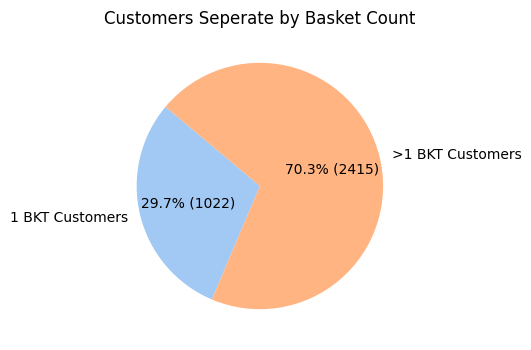

In [310]:
cust_one_bkt = len(df_scv.loc[df_scv['total_trans']==1])
cust_morethanone_bkt = len(df_scv.loc[df_scv['total_trans']>1])

# Data
values = [cust_one_bkt, cust_morethanone_bkt]
labels = ['1 BKT Customers', '>1 BKT Customers']

# Calculate the total count
total = sum(values)

# Create a pie chart
plt.figure(figsize=(4, 4))  # Adjust the figure size if needed
colors = sns.color_palette('pastel')[0:len(values)]  # Use Seaborn pastel colors
plt.pie(values, labels=labels, colors=colors, autopct=lambda p: f'{p:.1f}% ({int(p * total / 100)})', startangle=140)

# Add a title to the chart
plt.title('Customers Seperate by Basket Count')

# Display the chart
plt.show()

## K-Mean Clustering

### 1 Basket customers

In [343]:
df_feature = df_scv.loc[df_scv['total_trans']==1, ['avg_bkt_size', 'total_spend']]
col_X = df_feature.columns

scaler = StandardScaler()
X = scaler.fit_transform(df_feature)

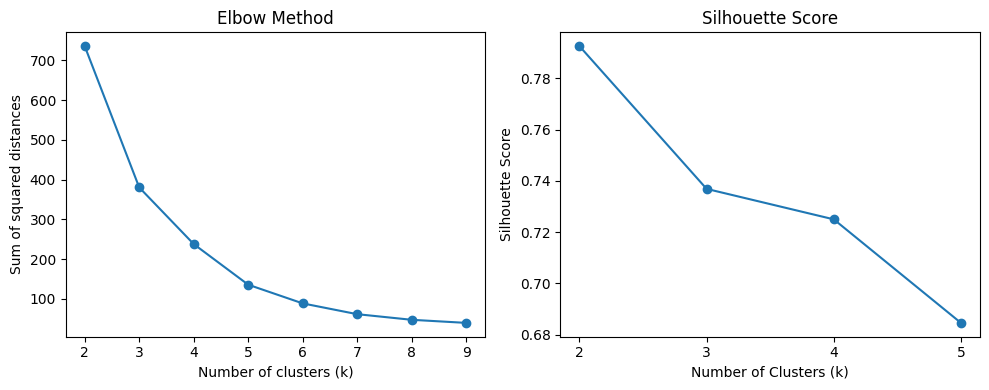

In [344]:
### Elbow
k_values = range(2, 10)
inertia_values = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)


### Silhouette
silhouette_scores = []

for k in range(2, 6):
    # Create a KMeans object and fit the data
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)

    # Get the cluster labels for each sample
    labels = kmeans.labels_

    # Calculate silhouette score
    silhouette_avg = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_avg)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)

axes[0].plot(k_values, inertia_values, marker='o')
axes[0].set_xlabel('Number of clusters (k)')
axes[0].set_ylabel('Sum of squared distances')
axes[0].set_title('Elbow Method')

axes[1].plot(range(2, 6), silhouette_scores, marker='o')
axes[1].set_title('Silhouette Score')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_xticks(range(2, 6))

plt.show()

In [349]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)

# Get cluster labels and cluster centers
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Add cluster labels to the DataFrame
df_feature['Cluster'] = labels
df_feature.tail(3)

,avg_bkt_size,total_spend,Cluster
3436,0.63,0.63,1
3437,1.54,1.54,1
3438,0.03,0.03,1


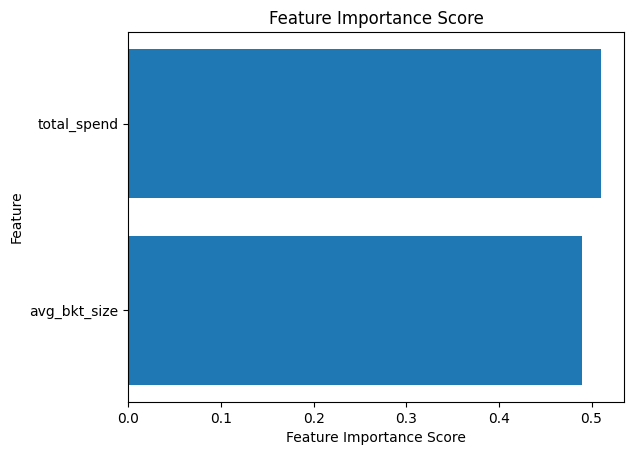

In [350]:
# Create a Random Forest classifier
clf = RandomForestClassifier(random_state=42)

# Train the classifier on your data
clf.fit(X, labels)

# Get the feature importance scores
importance_scores = clf.feature_importances_

# Sort the features based on importance in descending order
sorted_indices = np.argsort(importance_scores)[::-1]

# # Print the feature rankings
# for i, idx in enumerate(sorted_indices):
#     print(f"Rank {i}: Feature {df_clus.columns[idx]}, Importance score: {importance_scores[idx]}")

# Plotting the feature importance
plt.barh(range(len(sorted_indices)), importance_scores[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), [col_X[idx] for idx in sorted_indices])
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance Score')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance on top
plt.show()

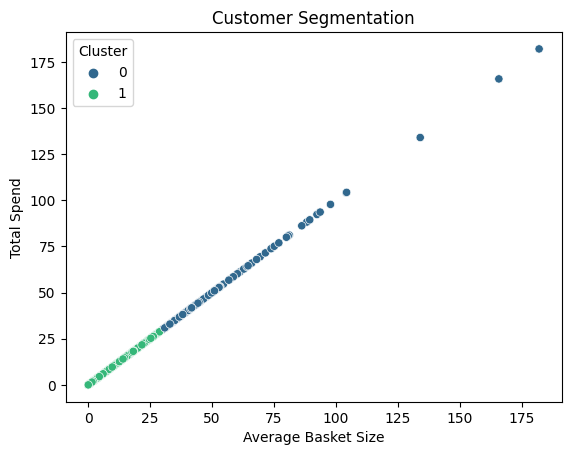

In [351]:
# Create a scatter plot
sns.scatterplot(data=df_feature, x='avg_bkt_size', y='total_spend', hue='Cluster', palette='viridis')

# Add labels and title
plt.xlabel('Average Basket Size')
plt.ylabel('Total Spend')
plt.title('Customer Segmentation')

# Show the legend
plt.legend(title='Cluster')

# Show the plot
plt.show()

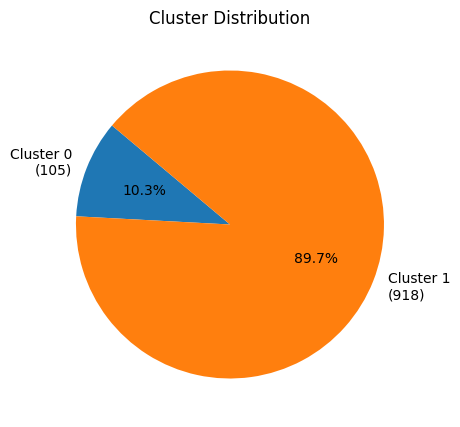

In [352]:
# Calculate label counts
unique_labels, label_counts = np.unique(labels, return_counts=True)

# Create a pie chart
plt.figure(figsize=(5, 5))  # Adjust the figure size if needed
patches, texts, autotexts = plt.pie(
    label_counts,
    labels=[f'Cluster {label}' for label in unique_labels],
    autopct='%1.1f%%',
    startangle=140,  # Adjust the start angle as needed
)

# Add count numbers next to the slices
for i, label in enumerate(unique_labels):
    texts[i].set_text(f'Cluster {label}\n({label_counts[i]})')

# Add a title to the chart
plt.title('Cluster Distribution')

# Display the chart
plt.show()

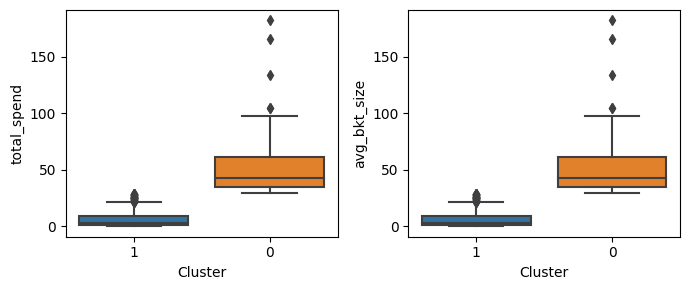

In [373]:
df_feature['Cluster'] = df_feature['Cluster'].astype(str)
num_var = df_feature.select_dtypes(include=['float64', 'int64']).columns.to_list()
column = [num_var[idx] for idx in sorted_indices]

fig, axes = plt.subplots(1, 2, figsize=(7, 3), tight_layout=True)

for i, feature in enumerate(column):
    sns.boxplot(data=df_feature, y=feature, x='Cluster', ax=axes[i])
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(feature)

plt.show()

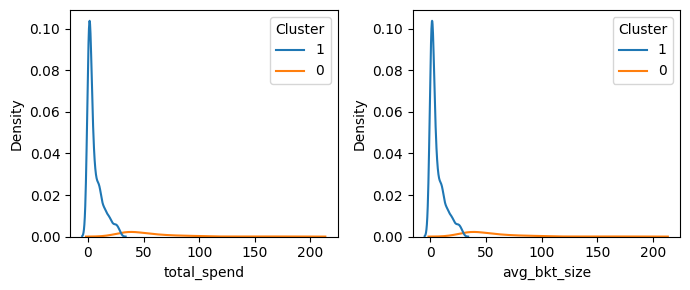

In [372]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3), tight_layout=True)

for i, feature in enumerate(column):
    sns.kdeplot(data=df_feature, x=feature, hue='Cluster', ax=axes[i])
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')

plt.show()

In [319]:
desc = df_feature.groupby('Cluster').describe()
for col in column:
    display(HTML(f"{col.upper()}"))
    display(desc[col].style.bar(color='turquoise'))
    display(HTML(''))

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,33.000000,82.166970,29.352938,56.760000,62.820000,73.800000,89.410000,181.970000
1,835.000000,4.397042,4.411159,0.010000,0.980000,2.470000,6.685000,17.000000
2,155.000000,30.089871,10.049920,17.390000,21.385000,28.070000,37.075000,54.590000


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,33.000000,82.166970,29.352938,56.760000,62.820000,73.800000,89.410000,181.970000
1,835.000000,4.397042,4.411159,0.010000,0.980000,2.470000,6.685000,17.000000
2,155.000000,30.089871,10.049920,17.390000,21.385000,28.070000,37.075000,54.590000


### >1 Basket customers

In [320]:
df_feature = df_scv.loc[df_scv['total_trans']>=1].drop(columns=['CUST_CODE', 'last_visit', 'most_buying_pdt', 'mem_dur'])
col_X = df_feature.columns

scaler = StandardScaler()
X = scaler.fit_transform(df_feature)

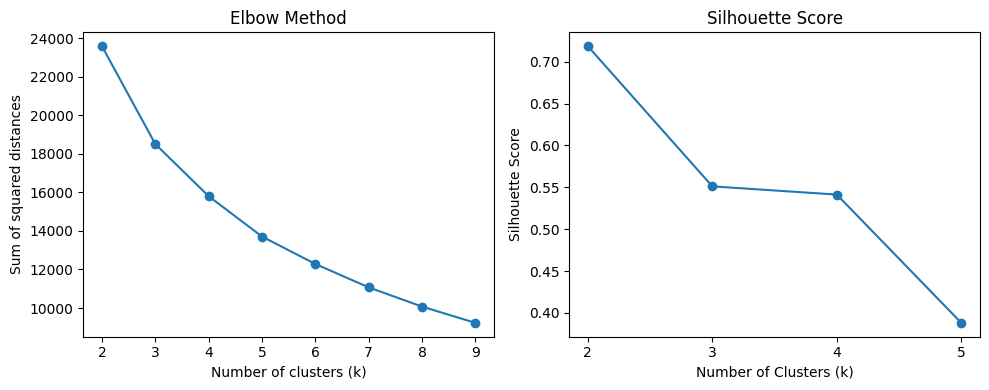

In [321]:
### Elbow
k_values = range(2, 10)
inertia_values = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)


### Silhouette
silhouette_scores = []

for k in range(2, 6):
    # Create a KMeans object and fit the data
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)

    # Get the cluster labels for each sample
    labels = kmeans.labels_

    # Calculate silhouette score
    silhouette_avg = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_avg)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)

axes[0].plot(k_values, inertia_values, marker='o')
axes[0].set_xlabel('Number of clusters (k)')
axes[0].set_ylabel('Sum of squared distances')
axes[0].set_title('Elbow Method')

axes[1].plot(range(2, 6), silhouette_scores, marker='o')
axes[1].set_title('Silhouette Score')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_xticks(range(2, 6))

plt.show()

In [336]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

# Get cluster labels and cluster centers
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Add cluster labels to the DataFrame
df_feature['Cluster'] = labels
df_feature.tail(3)

,avg_bkt_size,total_trans,total_spend,avg_bkt_size_3m,total_trans_3m,total_spend_3m,avg_bkt_size_6m,total_trans_6m,total_spend_6m,tbp,spending_per_day,trans_per_day,Cluster
3436,0.63,1,0.63,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.002825,0.004484,0
3437,1.54,1,1.54,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.009390,0.006098,0
3438,0.03,1,0.03,0.0,0.0,0.0,0.03,1.0,0.03,0.0,0.000259,0.008621,0


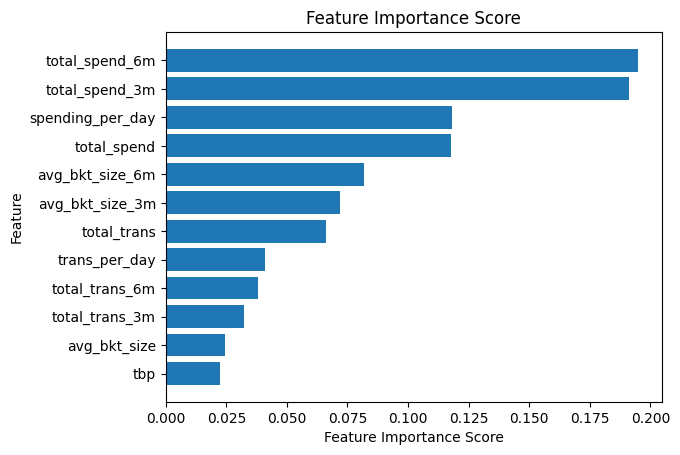

In [337]:
# Create a Random Forest classifier
clf = RandomForestClassifier(random_state=42)

# Train the classifier on your data
clf.fit(X, labels)

# Get the feature importance scores
importance_scores = clf.feature_importances_

# Sort the features based on importance in descending order
sorted_indices = np.argsort(importance_scores)[::-1]

# # Print the feature rankings
# for i, idx in enumerate(sorted_indices):
#     print(f"Rank {i}: Feature {df_clus.columns[idx]}, Importance score: {importance_scores[idx]}")

# Plotting the feature importance
plt.barh(range(len(sorted_indices)), importance_scores[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), [col_X[idx] for idx in sorted_indices])
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance Score')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance on top
plt.show()

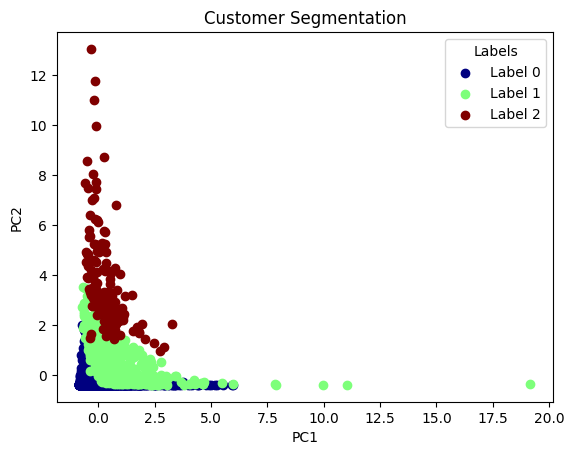

In [338]:
# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Get unique labels and assign colors
unique_labels = np.unique(labels)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))

# Create a scatter plot with legends
scatter = []
for i, label in enumerate(unique_labels):
    mask = (labels == label)
    scatter.append(plt.scatter(X[mask, 0], X[mask, 1], c=[colors[i]], label=f'Label {label}'))

# Add labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Customer Segmentation')

# Add a legend
plt.legend(handles=scatter, title='Labels')

# Show the plot
plt.show()

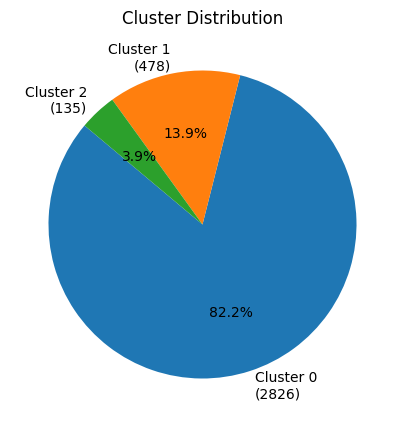

In [339]:
# Calculate label counts
unique_labels, label_counts = np.unique(labels, return_counts=True)

# Create a pie chart
plt.figure(figsize=(5, 5))  # Adjust the figure size if needed
patches, texts, autotexts = plt.pie(
    label_counts,
    labels=[f'Cluster {label}' for label in unique_labels],
    autopct='%1.1f%%',
    startangle=140,  # Adjust the start angle as needed
)

# Add count numbers next to the slices
for i, label in enumerate(unique_labels):
    texts[i].set_text(f'Cluster {label}\n({label_counts[i]})')

# Add a title to the chart
plt.title('Cluster Distribution')

# Display the chart
plt.show()

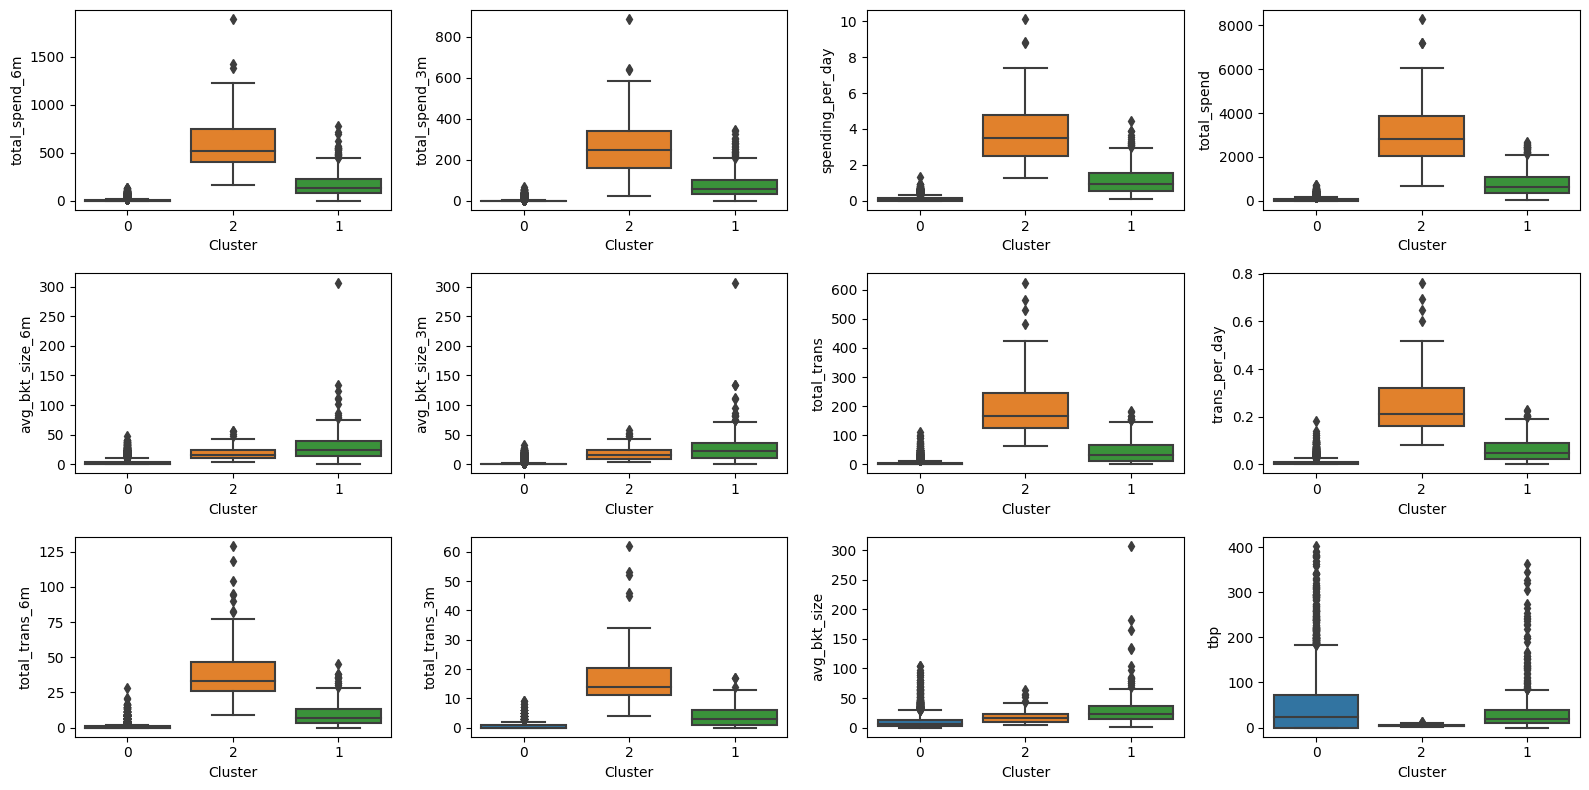

In [340]:
df_feature['Cluster'] = df_feature['Cluster'].astype(str)
num_var = df_feature.select_dtypes(include=['float64', 'int64']).columns.to_list()
column = [num_var[idx] for idx in sorted_indices]

fig, axes = plt.subplots(3, 4, figsize=(16,8), tight_layout=True)
row = 0
col = 0
for feature in column:
    sns.boxplot(data=df_feature, y=feature, x='Cluster', ax=axes[row, col])
    col += 1
    if col == 4:
        col = 0
        row += 1
plt.show()

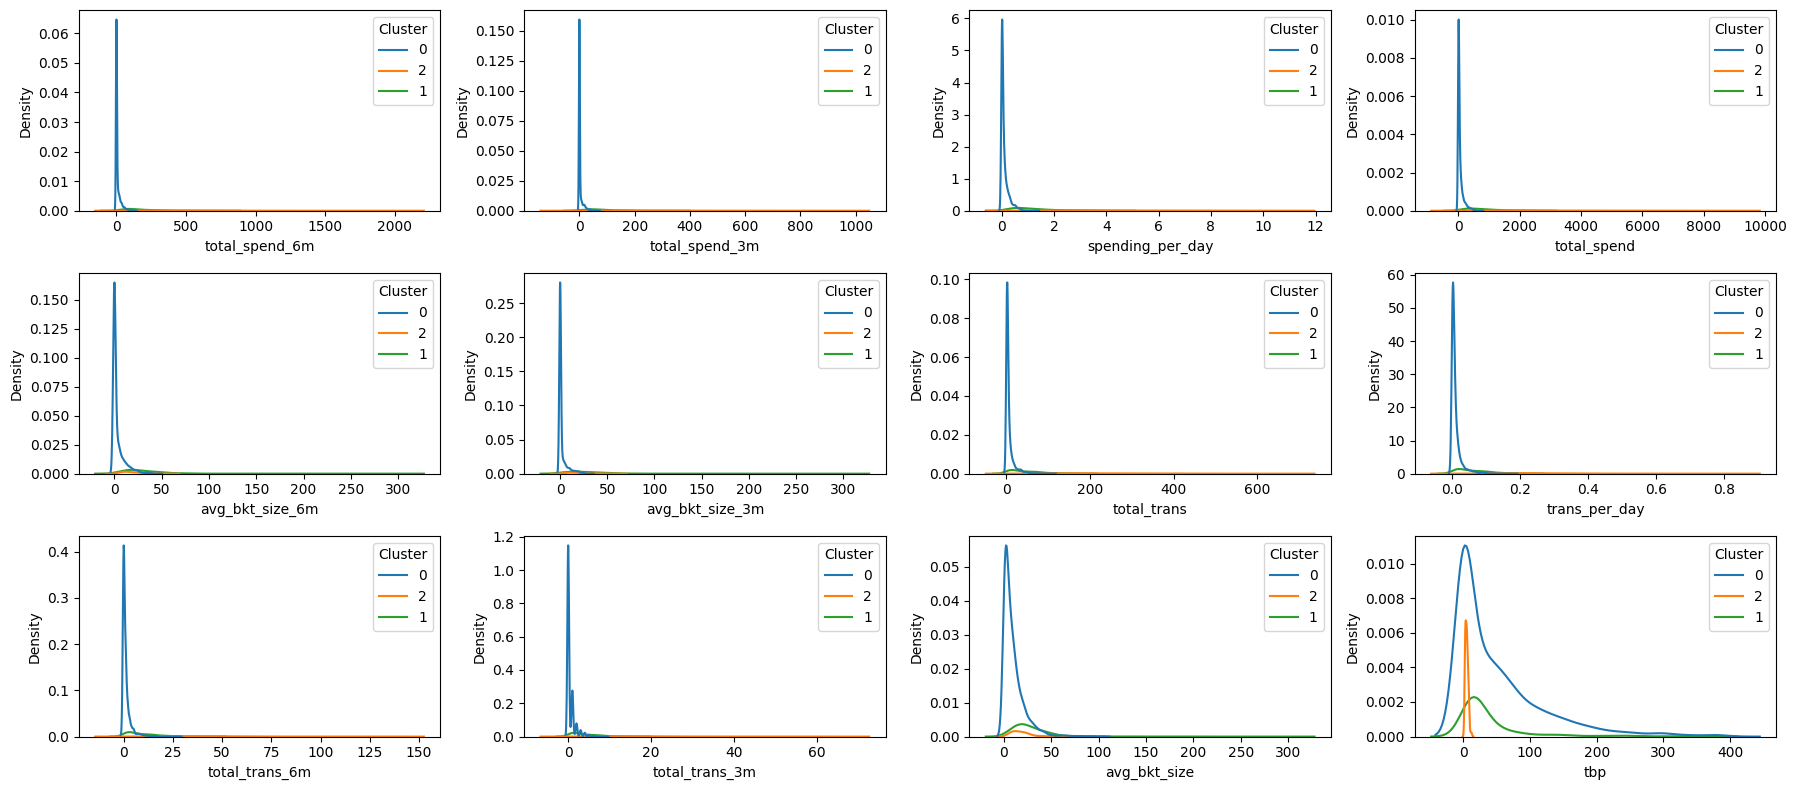

In [341]:
fig, axes = plt.subplots(3, 4, figsize=(18,8), tight_layout=True)
row = 0
col = 0
for feature in column:
    sns.kdeplot(data=df_feature, x=feature, hue='Cluster', ax=axes[row, col])
    col += 1
    if col == 4:
        col = 0
        row += 1
plt.show()

In [342]:
desc = df_feature.groupby('Cluster').describe()
for col in column:
    display(HTML(f"{col.upper()}"))
    display(desc[col].style.bar(color='turquoise'))
    display(HTML(''))

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,2826.000000,8.251886,17.469391,0.000000,0.000000,0.000000,7.435000,133.480000
1,478.000000,169.551109,128.337942,0.000000,76.732500,130.665000,225.527500,777.000000
2,135.000000,593.378519,280.865727,163.670000,399.075000,522.120000,746.260000,1893.210000


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,2826.000000,3.083857,7.892227,0.000000,0.000000,0.000000,0.750000,69.420000
1,478.000000,76.651025,62.905271,0.000000,34.407500,58.070000,103.255000,344.960000
2,135.000000,265.557111,144.856152,22.390000,161.230000,246.380000,339.015000,885.630000


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,2826.000000,0.099669,0.144838,0.000018,0.009100,0.035917,0.128328,1.338566
1,478.000000,1.135866,0.783093,0.076190,0.553628,0.954348,1.520520,4.425644
2,135.000000,3.790223,1.632271,1.270919,2.511847,3.513215,4.785898,10.124279


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,2826.000000,57.442537,93.796446,0.010000,3.865000,17.545000,66.857500,739.940000
1,478.000000,790.658264,598.044497,47.740000,344.900000,620.175000,1062.980000,2680.450000
2,135.000000,3031.116074,1376.374540,659.660000,2024.375000,2833.060000,3878.950000,8281.660000


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,2826.000000,3.372906,6.357550,0.000000,0.000000,0.000000,4.132833,46.850000
1,478.000000,29.215969,23.071483,0.000000,14.594687,24.155576,39.361875,306.970000
2,135.000000,18.126492,10.880292,3.996066,10.131826,15.671333,23.888655,56.730714


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,2826.000000,1.839513,4.394565,0.000000,0.000000,0.000000,0.717500,32.840000
1,478.000000,25.847061,23.793814,0.000000,10.898409,21.911000,35.471250,306.970000
2,135.000000,18.323351,11.572913,3.195000,9.210353,15.637778,24.149596,57.936250


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,2826.000000,6.240623,10.350501,1.000000,1.000000,2.000000,6.000000,112.000000
1,478.000000,43.707113,37.570869,1.000000,13.000000,34.000000,67.000000,183.000000
2,135.000000,197.266667,100.813793,64.000000,126.500000,168.000000,245.500000,624.000000


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,2826.000000,0.010900,0.015352,0.001222,0.002833,0.005521,0.011976,0.183007
1,478.000000,0.060694,0.048240,0.001350,0.021698,0.048531,0.090263,0.226700
2,135.000000,0.250090,0.125272,0.080402,0.160856,0.212422,0.318851,0.762836


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,2826.000000,1.144020,2.246758,0.000000,0.000000,0.000000,1.000000,28.000000
1,478.000000,8.928870,7.907694,0.000000,3.000000,7.000000,13.000000,45.000000
2,135.000000,39.348148,20.862492,9.000000,26.000000,33.000000,46.500000,129.000000


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,2826.000000,0.476645,1.012306,0.000000,0.000000,0.000000,1.000000,9.000000
1,478.000000,3.799163,3.217718,0.000000,1.000000,3.000000,6.000000,17.000000
2,135.000000,17.103704,9.502768,4.000000,11.000000,14.000000,20.500000,62.000000


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,2826.000000,9.999760,11.749366,0.010000,2.160000,6.330000,13.385682,104.290000
1,478.000000,27.951650,23.706278,1.765274,15.098790,22.563706,35.800625,306.970000
2,135.000000,18.186391,11.013786,3.840293,10.346167,16.712117,22.804291,63.061667


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,2826.000000,49.908815,68.400844,0.000000,0.000000,24.387097,73.166667,402.500000
1,478.000000,38.806236,55.371932,0.000000,10.355769,18.496609,39.387500,363.500000
2,135.000000,4.883147,2.130878,1.310897,3.130329,4.670588,6.173673,12.437500
